In [87]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The original dataset was saved in ./dataset folder of the repository.
Following code will read it, split and save into full_train part for training and validating purposes and test part

In [88]:
data = pd.read_csv("./dataset/car_prices.csv", sep=",", on_bad_lines='skip')

data_full_train, data_test = train_test_split(data, test_size=0.2, random_state=9)

data_full_train.to_csv("./dataset/car_prices_full_train.csv", index=False)
data_test.to_csv("./dataset/car_prices_test.csv", index=False)

In [90]:
def dataset_cleaning(df):
    """
    pd.DataFrame -> pd.DataFrame
    Initial cleaning of the data:
     - lower case converting
     - replacing spaces with "_"
     - datetime format transformation
    """
    
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    df.saledate = pd.to_datetime(df.saledate)

    categorical_cols = df.select_dtypes(["object"]).columns.to_list()
    categorical_cols.remove("saledate")

    for col in categorical_cols:
        df[col] = df[col].str.lower().str.replace(" ", "_")
    
    return df

Reading full_train dataset

In [91]:
df = pd.read_csv("./dataset/car_prices_full_train.csv", sep=",", on_bad_lines='skip')
df = dataset_cleaning(df)

df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2012,mercedes-benz,gl-class,gl450_4matic,suv,automatic,4jgbf7be1ca781842,nv,2.6,62622.0,black,black,the_hertz_corporation,25900,24800,2015-01-09 12:00:00+08:00
1,2012,honda,pilot,ex-l,suv,automatic,5fnyf4h74cb027511,tn,2.6,33268.0,gray,black,eurofix,24100,26000,2015-02-11 02:30:00+08:00
2,2012,hyundai,sonata,se,sedan,NaN,5npec4ab9ch415040,pa,1.9,19270.0,white,black,hyundai_motor_finance,14750,13000,2015-02-27 01:00:00+08:00
3,2013,infiniti,g_sedan,g37_journey,g_sedan,automatic,jn1cv6ap5dm720571,ca,4.9,15802.0,silver,black,nissan_infiniti_lt,23800,25000,2014-12-18 12:30:00+08:00
4,2013,volkswagen,passat,se_pzev,sedan,automatic,1vwbp7a3xdc111419,tx,4.4,56186.0,gray,black,hopper_motorplex_inc,10800,10900,2015-06-03 03:15:00+07:00


There are:
- 4 number columns - condition, odometer, mmr, sellingprice
- 10 categorical columns - make, model, trim, body, transmission, vin, state, color, interior, seller
- and 2 date columns - year, saledate

In [4]:
df.dtypes

year              int64
make             object
model            object
trim             object
body             object
transmission     object
vin              object
state            object
condition       float64
odometer        float64
color            object
interior         object
seller           object
mmr               int64
sellingprice      int64
saledate         object
dtype: object

The following description table among standart count, mean, min/max, std parameters represents quantile distribution of dataset mass.
The most interesting things:
- need to investigate 1 and 999999 values in odometer feature  almost

In [85]:
df.describe(percentiles=[0.05, 0.50, 0.99, 0.995])

,year,condition,odometer,mmr,sellingprice
count,447048.000000,437745.000000,446975.000000,447048.000000,447048.00000
mean,2010.036065,3.423992,68324.364320,13764.158826,13604.35519
std,3.968462,0.949047,53216.639826,9685.817507,9746.97654
min,1982.000000,1.000000,1.000000,25.000000,1.00000
5%,2002.000000,1.900000,10519.700000,1800.000000,1500.00000
50%,2012.000000,3.600000,52294.000000,12250.000000,12100.00000
99%,2015.000000,5.000000,226699.260000,44800.000000,44750.00000
99.5%,2015.000000,5.000000,250951.390000,52700.000000,52750.00000
max,2015.000000,5.000000,999999.000000,182000.000000,183000.00000


In [5]:
# Number of unique
cat_features = [
    "make",
    "model",
    "trim",
    "body",
    "transmission",
    "vin",
    "state",
    "color",
    "interior",
    "seller",
    ]

for col in df[cat_features]:
    print("%15s" %col, "%10s" %df[col].nunique())

           make         63
          model        839
           trim       1850
           body         44
   transmission          2
            vin     441621
          state         38
          color         20
       interior         17
         seller      13197


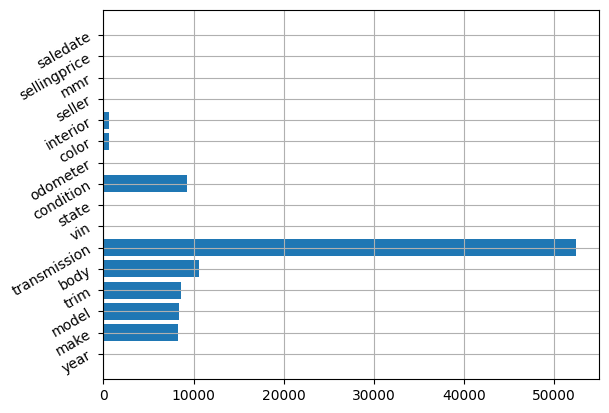

In [6]:
# dropna before EDA ?
df_nulls = df.isnull().sum()

plt.barh(width=df_nulls.values, y = range(df_nulls.shape[0]))
plt.yticks(range(df_nulls.shape[0]), df_nulls.index, rotation=30)
plt.grid()
plt.show()


Exploratory data analysis

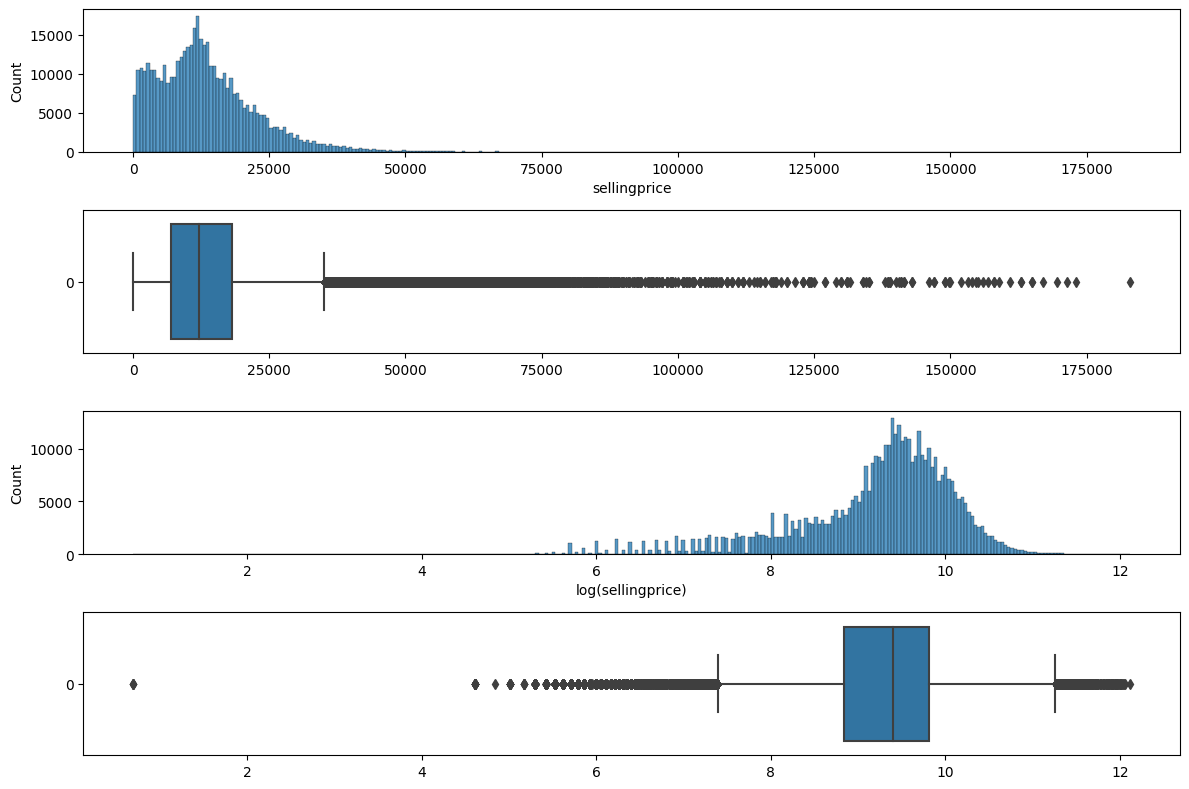

In [41]:
# sellingprice

fig, axes = plt.subplots(4,1, figsize=(12,8))
sns.histplot(df.sellingprice, bins=300, ax=axes[0])
sns.boxplot(df.sellingprice, orient='horizontal', ax=axes[1])
# axes[1].set_xlabel("sellingprice")

sns.histplot(np.log1p(df.sellingprice), bins=300, thresh=0.5, ax=axes[2])
sns.boxplot(np.log1p(df.sellingprice), orient='horizontal', ax=axes[3])
axes[2].set_xlabel("log(sellingprice)")

plt.tight_layout()
plt.show()

In [81]:
display(df[df.sellingprice == min(df.sellingprice)])

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
36977,1995,isuzu,rodeo,ls,suv,NaN,4s2cm58v9s4375559,va,1.0,254132.0,red,gray,automotive_remarketing_inc,375,1,2015-03-04 01:05:00+08:00
60195,2003,mercedes-benz,e-class,e500,sedan,automatic,wdbuf70j73a269529,ga,2.1,1.0,black,black,peoples_credit_company_inc,7325,1,2015-01-06 09:30:00+08:00
126491,2014,ford,e-series_van,e-250,e-series_van,automatic,1ftne2ew6eda13643,tx,4.1,31886.0,white,gray,u-haul,20800,1,2015-02-12 03:00:00+08:00
280197,2002,ford,f-350_super_duty,xlt,crew_cab,NaN,1ftsw31f52ed16477,ca,2.0,NaN,white,gray,laa_leasing,7850,1,2015-02-05 04:00:00+08:00


In [82]:
display(df[df.sellingprice == max(df.sellingprice)])

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
379179,2011,ferrari,458_italia,base,coupe,automatic,zff67nfa1b0178698,fl,4.6,12116.0,red,black,platinum_motor_cars,182000,183000,2015-06-17 03:40:00+07:00


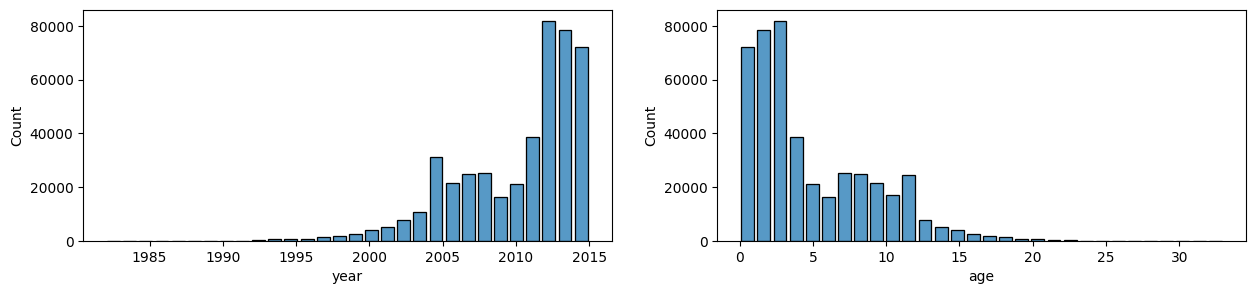

In [83]:
# year
fig, axes = plt.subplots(1,2, figsize=(15,3))
sns.histplot(df.year, ax=axes[0], shrink=0.8, bins=30)
sns.histplot(df.age, ax=axes[1], shrink=0.8, bins=30)
plt.show()

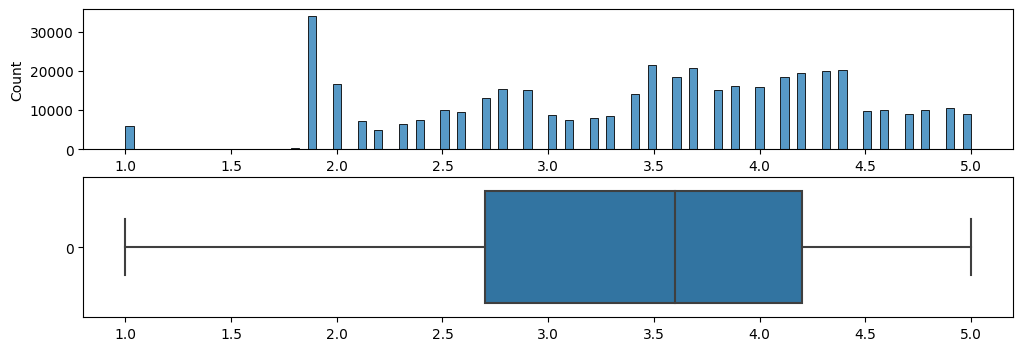

In [48]:
# condition
fig, axes = plt.subplots(2,1, figsize=(12,4))
sns.histplot(df.condition, ax=axes[0])
sns.boxplot(df.condition, ax=axes[1], orient='horizontal')
plt.show()

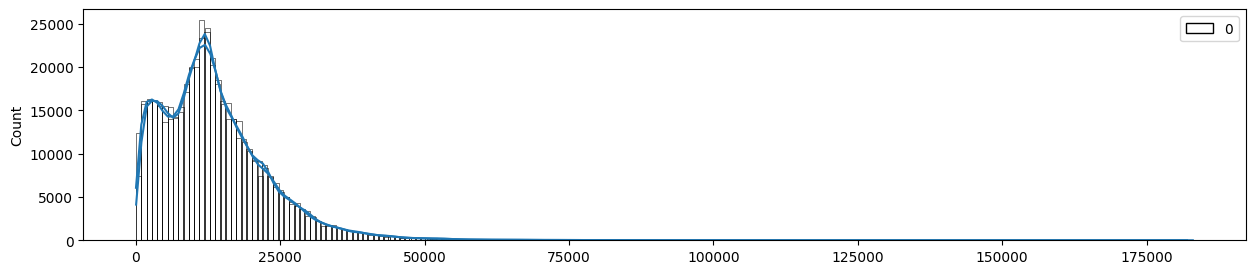

In [50]:
# mmr and sellingprice columns almost completly correspond

plt.figure(figsize=(15,3))
sns.histplot(df["mmr"].values.reshape([-1,1]), bins=200, alpha=0.5, color='b', facecolor='none', kde=True)
sns.histplot(df["sellingprice"].values.reshape([-1,1]), bins=200, alpha=0.5, color='r', facecolor='none', kde=True)

plt.show()


Second min odometer value 2.0
Second max odometer value 959276.0


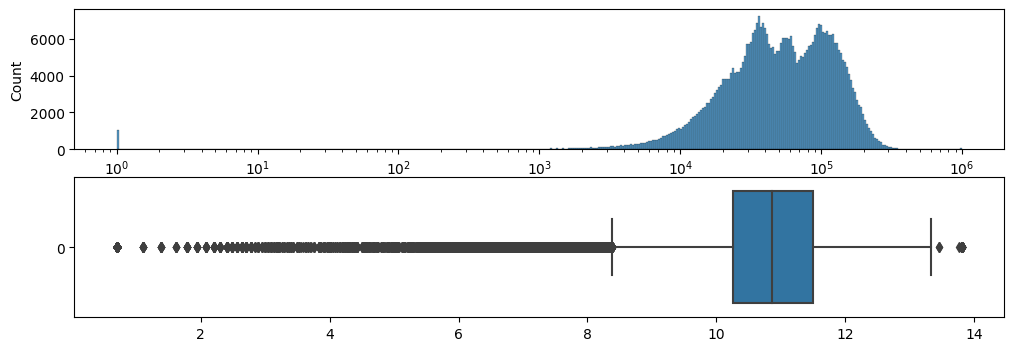

In [55]:
# odometer

min_odometer = min(df.odometer)
next_min = min(list(filter(lambda x: x > min_odometer, df.odometer)))
print(f"Second min odometer value {next_min}")

max_odometer = max(df.odometer)
next_max = max(list(filter(lambda x: x < max_odometer, df.odometer)))
print(f"Second max odometer value {next_max}")

fig, axes = plt.subplots(2,1, figsize=(12,4))
sns.histplot(df.odometer, ax=axes[0], log_scale=True)
sns.boxplot(np.log1p(df.odometer), ax=axes[1], orient='horizontal')
plt.show()

/tmp/ipykernel_2599/3436689179.py:11: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(column=num_columns, bins=200, layout=(2,3), ax=ax)


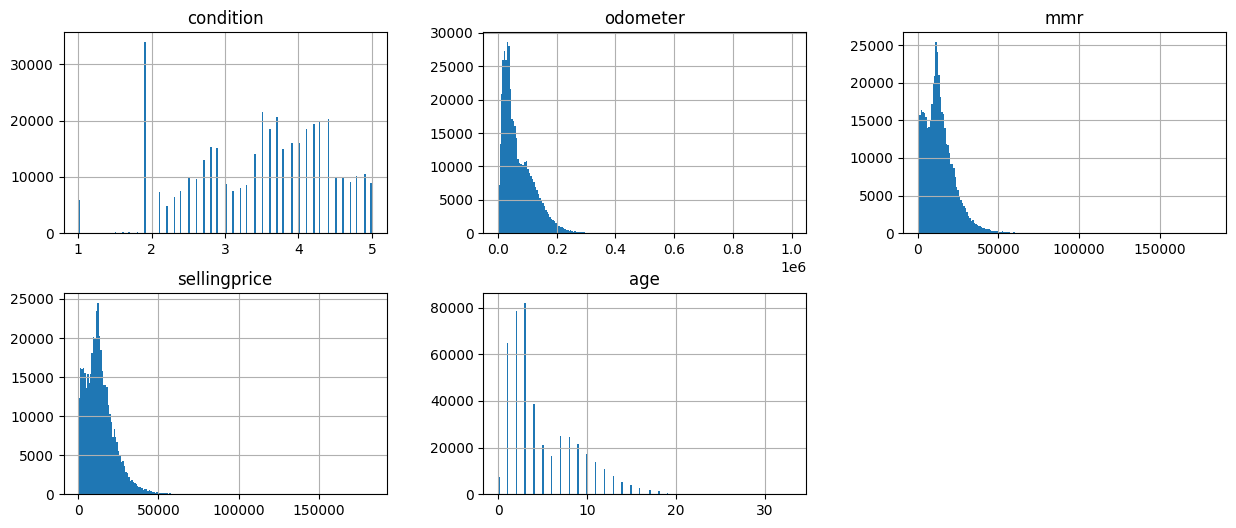

In [45]:
num_columns = [
    "condition",
    "odometer",
    "mmr",
    "sellingprice",
    "age"
]

plt.figure(figsize=(15,6))
ax = plt.gca()
df.hist(column=num_columns, bins=200, layout=(2,3), ax=ax)
plt.xscale("log")
plt.show()

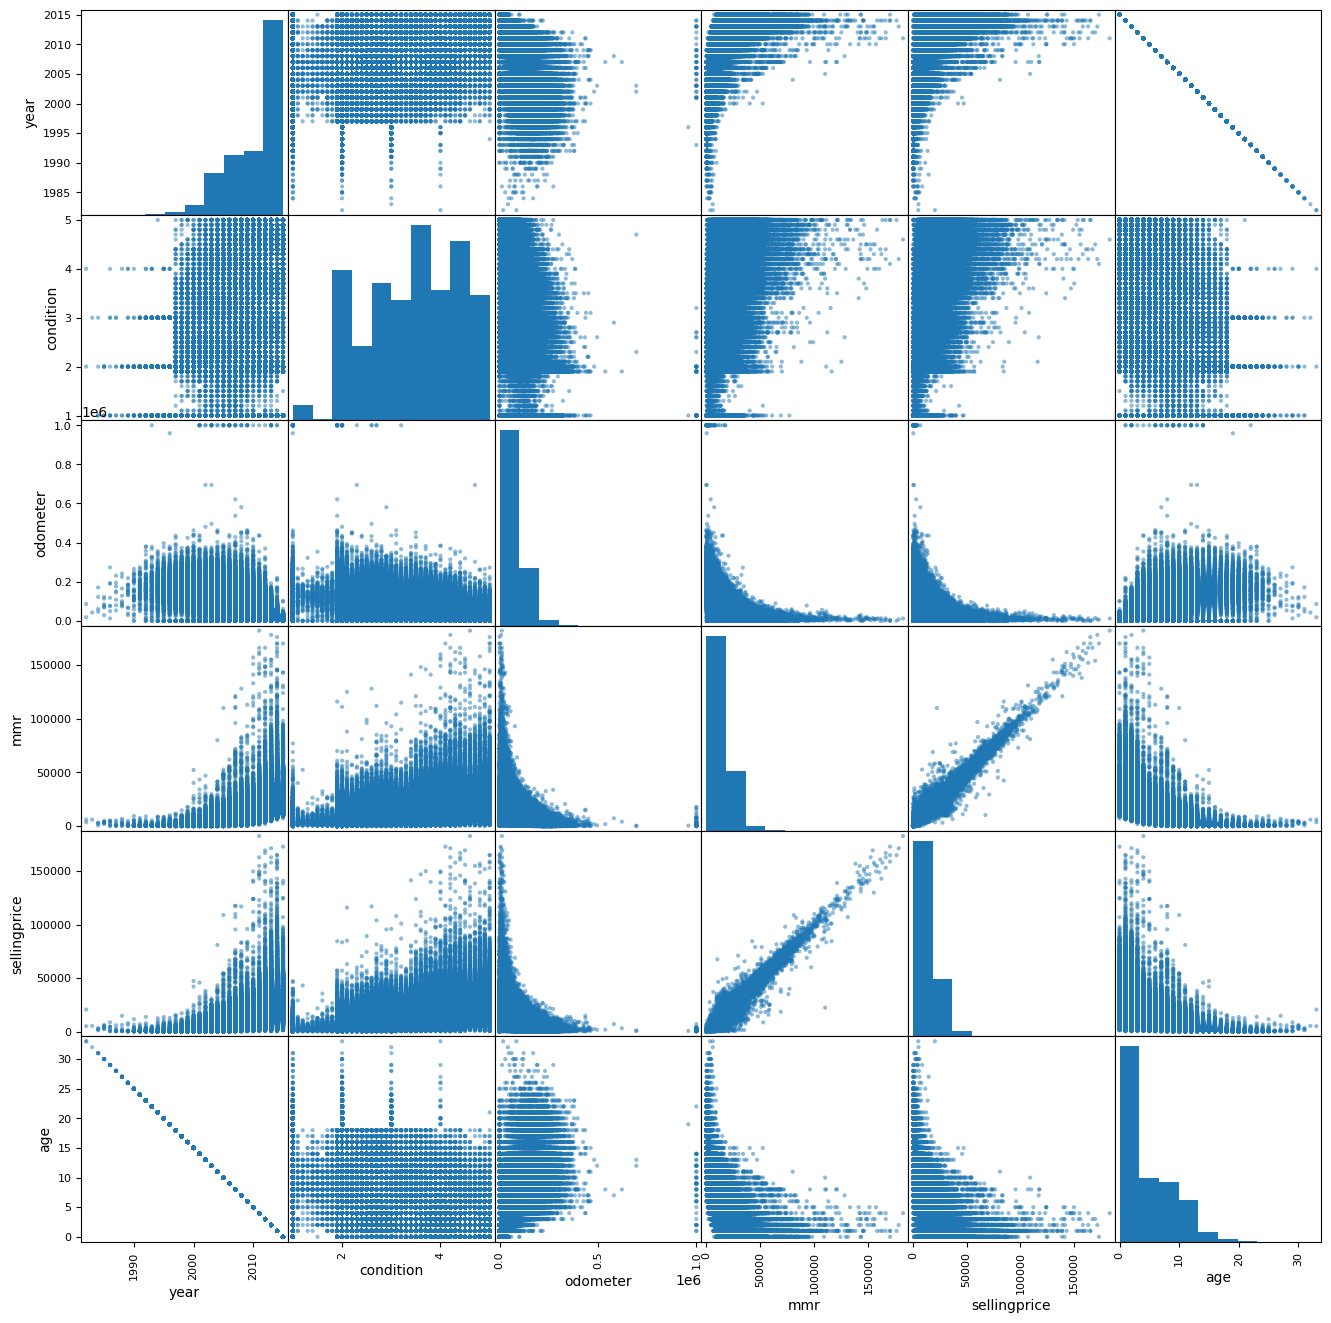

In [197]:

pd.plotting.scatter_matrix(df, figsize=(16,16))
plt.show()

Features importance

In [70]:
features = [
    "year",
    "make",
    "model",
    "trim",
    "body",
    "transmission",
    "state",
    "condition",
    "odometer",
    "mmr",
    "color",
    "interior",
    "seller",
    "sellingprice"
]

numeric_features = [
    'year',
    'condition',
    'odometer',
    'mmr'
    ]

additional_features = [
    'age',
    'noise',
    'reversed_odometer'
    ]

df_plus_features = df[features].dropna().copy()
df_plus_features["age"] = max(df_plus_features.year) - df_plus_features.year
df_plus_features["reversed_odometer"] = 1. / df_plus_features.odometer


In [71]:
# Lets add a random noise feature to out dataset
rnd = np.random.RandomState(5)

size = len(df_plus_features)

df_plus_features["noise"] = rnd.random(size=size)

In [72]:
mi_score_cat = pd.Series(dtype="float")
cat_features = list(df_plus_features.select_dtypes("object").columns)

for col in df_plus_features[cat_features]:
    mi_score_cat.loc[col] = mutual_info_score(df_plus_features[col], df_plus_features["sellingprice"])

mi_score_cat.sort_values(ascending=False)

seller          1.401402
model           0.843560
trim            0.758266
make            0.244751
body            0.163685
state           0.137631
interior        0.062221
color           0.056911
transmission    0.005074
dtype: float64

In [73]:
mi_score_num = pd.Series(mutual_info_regression(df_plus_features[numeric_features + additional_features],
                                                df_plus_features["sellingprice"]
                                                ),
                        index = numeric_features + additional_features)

mi_score_num.sort_values(ascending=False)

mmr                  1.790498
year                 0.442810
age                  0.441558
reversed_odometer    0.419280
odometer             0.418825
condition            0.268977
noise                0.001601
dtype: float64

In [74]:
df_plus_features[numeric_features + additional_features].corrwith(df_plus_features["sellingprice"], method='pearson')

year                 0.579129
condition            0.536333
odometer            -0.579783
mmr                  0.984082
age                 -0.579129
noise               -0.000593
reversed_odometer   -0.051862
dtype: float64

In [215]:
agg_funcs = ["mean", "median", "min", "max", "nunique"]

for make in dff.make.unique():
    mask = dff.make == make
    # dff.groupby(by=["make", "body"]).agg({"sellingprice": agg_funcs}).round(1)
    
    print(f"{make}")
    display(dff[mask].groupby(by=["body"]).agg({"sellingprice": agg_funcs}).round(1))

mercedes-benz


sellingprice                                
                    mean   median    min     max nunique
body                                                    
convertible      23335.6  18200.0    350  127000     392
coupe            22333.8  23400.0    700  124500     271
hatchback         3768.8   2400.0    575   28750      30
sedan            20294.1  20000.0      1  173000     662
suv              24527.3  23900.0    300  141000     587
van              24477.1  25600.0  10600   39500      43
wagon             9466.1   7900.0    350   49500     159

honda


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible      12948.4  12900.0  6300  27800      31
coupe             7792.3   7100.0   200  27750     271
crew_cab         17480.8  16400.0  4650  33000     119
hatchback        11709.1  11200.0   300  27750     227
minivan          12068.2  10100.0   250  36250     392
sedan             9668.4  10800.0   200  27600     365
suv              14968.7  15600.0   300  37000     414
wagon              383.3    400.0   300    450       3

infiniti


sellingprice                               
                        mean   median    min    max nunique
body                                                       
convertible          18587.5  18275.0  14200  21900      12
coupe                 9142.0   8550.0   1300  19250     142
g37_convertible      19881.2  20000.0  13500  26200      14
g37_coupe            15295.0  15450.0  10900  19400      10
g_convertible        26447.4  26000.0  18250  38250      89
g_coupe              22487.8  22500.0  10250  44700     143
g_sedan              20000.4  20000.0   9500  44000     177
q60_convertible      36848.6  36650.0  31000  42200      28
q60_coupe            29593.3  29000.0  25200  38200      23
sedan                17606.0  21650.0    200  42800     395
suv                  26090.5  27550.0    350  75000     511

volkswagen


sellingprice                               
                           mean   median    min    max nunique
body                                                          
beetle_convertible      18374.4  18100.0  14500  24000      29
convertible              6849.2   5000.0    300  27800     154
hatchback                8730.1   8800.0    200  30100     266
minivan                  9552.4   9400.0   2000  20600     101
sedan                    9216.0   9900.0    200  30000     339
suv                     13695.6  13100.0    800  42000     247
wagon                    8262.1   7650.0    300  23750     165

cadillac


sellingprice                               
                    mean   median    min    max nunique
body                                                   
convertible      17882.4  19500.0    600  34500      16
coupe             4805.0   1350.0    325  44000      29
crew_cab         17397.7  18050.0   2400  43800      89
cts-v_coupe      36586.8  37100.0  30500  44000      19
cts_coupe        22668.9  22350.0  16200  31250      68
cts_wagon        16900.0  16750.0  11500  26000       8
sedan             9262.7   6400.0    200  46600     419
suv              21512.8  20400.0    350  83000     537

dodge


sellingprice                               
                     mean   median    min    max nunique
body                                                    
club_cab           5060.5   4600.0    400  12200      74
convertible       35775.0  34600.0  28700  43250       5
coupe             20290.6  19750.0    275  51700     287
crew_cab          19309.4  18300.0    800  41750     123
extended_cab       3234.3   1700.0    300  13700      26
mega_cab          20025.6  20000.0   7200  31500      35
minivan           10859.8  11100.0    225  30400     304
quad_cab          10444.5   9400.0    400  32000     308
ram_van            1200.0   1200.0   1200   1200       1
regular_cab        6304.4   5600.0    300  22000     111
sedan             10459.4  10100.0    200  39100     392
suv               12431.9  11700.0    100  39000     417
van                7927.8   7450.0    400  19300      60
wagon              4729.9   4200.0    300  19600     141

lexus


sellingprice                               
                    mean   median    min    max nunique
body                                                   
convertible      20878.8  22100.0   4700  40200     124
coupe            18977.8   3300.0    200  66500      21
hatchback        19778.8  19400.0  11600  33600     112
sedan            18651.9  19600.0    200  67000     567
suv              23412.2  26000.0   1400  79750     527
wagon             4500.0   3600.0   2900   8500       5

ford


sellingprice                               
                     mean   median    min    max nunique
body                                                    
convertible       13661.5  13600.0    400  59400     329
coupe             14778.7  15000.0    300  58600     430
crew_cab          22986.3  21400.0    650  58500     559
e-series_van      18859.9  20000.0      1  24700     173
extended_cab       1840.8   1600.0    300   8300      55
hatchback         10385.4  10600.0    200  31700     242
minivan            7619.0   7600.0    100  33300     237
regular-cab       17288.9  17200.0  16400  18200       7
regular_cab       11593.1  11200.0    200  34300     261
sedan             11105.4  11200.0    200  42100     434
supercab          13523.8  12250.0    200  41300     391
supercrew         22570.0  23700.0    325  65000     527
suv               16867.8  17200.0    200  52750     612
transit_van       24037.5  24850.0  19500  27000      11
van               14041.1  17500.0    300  33000     287
wagon             14125.7  14400.0    175  34700     343

nissan


sellingprice                              
                     mean   median   min    max nunique
body                                                   
convertible       12663.4   9950.0  3500  34800      75
coupe             15359.7  13000.0   400  86400     267
crew_cab          15163.6  15750.0  1200  33400     284
extended_cab       2394.4   2600.0   900   3100       7
hatchback          9849.8  10000.0   525  67500     235
king_cab           9583.7   8500.0  1300  23800     158
minivan           10075.4   6800.0   350  28400     205
regular_cab        1542.3   1400.0   500   2600      10
sedan             11093.3  11800.0   100  37200     408
suv               13440.0  13900.0   200  41000     474
van               18040.0  19000.0  5600  33250      49
wagon              8226.0   7900.0  3100  14700      80

chevrolet


sellingprice                              
                     mean   median   min    max nunique
body                                                   
convertible       23706.9  22000.0   600  64200     252
coupe             14612.1  15000.0   200  84500     447
crew_cab          19577.4  18700.0   400  55500     520
double_cab        26511.2  26750.0  4000  59500      88
extended_cab      11348.0  10000.0   200  38750     339
hatchback          8609.7   8700.0   300  30000     226
minivan            2233.8   1800.0   225  10000      91
regular_cab        8440.9   7600.0   250  32200     235
sedan              8925.8   9300.0   100  37000     436
suv               14198.2  13100.0   200  59900     719
van               10896.0   8700.0   300  27800     275
wagon              5043.9   4900.0   500  12000     104

chrysler


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible       4517.7   2900.0   100  24800     164
coupe             2001.3   1225.0   250   6800      22
hatchback         5160.0   5025.0  2000   8750      18
minivan          13911.4  17100.0   300  31600     333
sedan            10348.0   9700.0   150  39100     399
suv               8975.9   9000.0  1600  17000      99
wagon             2535.0   2300.0   100  10200     108

toyota


sellingprice                              
                     mean   median   min    max nunique
body                                                   
access_cab        14185.3  15600.0  2000  26900     146
convertible        6076.5   5700.0   500  17400      71
coupe              3213.9   2800.0   150  12000      84
crewmax_cab       26359.5  26600.0  4600  43500     226
double_cab        22844.4  23700.0  2300  39600     264
extended_cab       3798.1   3350.0  1800   7700      23
hatchback          9720.1   9650.5   250  26000     266
minivan           13703.0  14800.0   800  35100     339
regular_cab       10731.0  12100.0   700  21600      90
sedan             10729.8  11400.0   150  37300     461
suv               15478.1  14900.0   300  64000     535
wagon             13972.7  15500.0   200  29600     204
xtracab            5893.5   5900.0  2400  10850      19

mazda


sellingprice                              
                     mean   median   min    max nunique
body                                                   
cab_plus           3266.7   4100.0  1300   4400       3
cab_plus_4         9375.0   9250.0  6500  12500       4
convertible       12740.5  12600.0   400  26250     116
coupe             10366.7  10000.0  5700  13800      11
extended_cab       1366.7   1550.0   800   1750       3
hatchback          9619.2   9200.0   400  23900     195
minivan            8805.6  10150.0   225  19500     174
regular_cab        1908.3   1950.0   600   3500       6
sedan              8699.0   9100.0   200  24750     297
suv               14471.8  16600.0   400  30900     290
wagon              2179.3   1750.0   300   6500      30

gmc


sellingprice                               
                     mean   median    min    max nunique
body                                                    
crew_cab          22997.5  23000.0   1100  57750     435
double_cab        27944.0  27400.0  18500  35900      40
extended_cab      13525.6  13700.0    700  31500     260
minivan            2180.0   2100.0   1550   3100       5
regular_cab        9776.5   9200.0    475  21250      95
suv               15115.6  14000.0    200  65000     556
van               19606.5  20200.0    800  37000      88

volvo


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible      11373.7  11150.0   275  28400      80
coupe             1000.0   1000.0  1000   1000       1
hatchback        12169.2  12350.0  5500  22200      25
sedan             9273.1   5400.0   200  28400     299
suv              13959.5  10900.0   900  34700     283
wagon            10577.3   4050.0   200  34000     163

scion


sellingprice                              
                  mean   median   min    max nunique
body                                                
coupe          17998.8  18500.0  9300  24100      76
hatchback       9027.6   8900.0   800  20000     175
wagon           8123.3   8000.0   800  16750     141

bmw


sellingprice                              
                    mean   median  min     max nunique
body                                                  
convertible      24247.5  23750.0  300  105500     494
coupe            24588.4  21500.0  150  165000     442
hatchback        37183.2  36750.0  900   57000     122
sedan            19040.0  17800.0  100  103000     683
suv              23069.6  23750.0  600   78000     570
wagon            18039.7  12700.0  225   45750      89

suzuki


sellingprice                               
                  mean   median    min    max nunique
body                                                 
crew_cab       14850.0  14850.0  14800  14900       2
hatchback       3571.5   3000.0    300   9500      57
sedan           3554.3   2600.0    300  12200     113
suv             4730.7   4200.0    350  13100     114
wagon           1376.2   1500.0    500   2500      17

ram


sellingprice                               
                            mean   median    min    max nunique
body                                                           
crew_cab                 29236.6  27800.0   7500  50750     391
extended_cab             10200.0  10000.0   7300  13800      15
mega_cab                 40655.9  40900.0  26500  54000      32
minivan                   8007.3   7200.0   3000  17200      40
promaster_cargo_van      23054.9  22800.0  17800  27400      29
quad_cab                 20908.5  21500.0   5700  38000     219
regular_cab              16308.9  16800.0   5000  30200     123

hyundai


sellingprice                              
                      mean   median   min    max nunique
body                                                    
elantra_coupe      12156.5  12100.0  2500  16300      38
genesis_coupe      15865.1  15700.0  1600  29400     116
hatchback           9677.9  10700.0   300  39500     214
minivan             4189.1   3750.0  1150  10500      36
sedan              11057.3  11400.0   100  55000     456
suv                11662.5  11200.0   325  36600     328
wagon               1416.7   1500.0   250   2500       3

lincoln


sellingprice                              
                 mean   median   min    max nunique
body                                               
coupe           900.0    750.0   450   2000       7
crew_cab      12541.5  12400.0  5700  23500      38
sedan         15905.9  16800.0   200  57400     353
suv           19686.8  22400.0   200  49000     422
wagon         23430.3  24000.0  9400  36500      83

mercury


sellingprice                            
                  mean  median  min    max nunique
body                                              
coupe            450.0   450.0  450    450       1
hatchback        845.0   700.0  225   2500      15
minivan         1957.7  1600.0  300   5200      28
sedan           3368.0  2600.0  150  13800     143
suv             5438.4  4800.0  250  18300     146
wagon            803.6   550.0  275   1600       6

subaru


sellingprice                               
                  mean   median    min    max nunique
body                                                 
coupe          19853.0  19500.0  15300  24400      27
crew_cab        6694.3   6200.0   1000  13200      26
hatchback      16378.1  16850.0   3800  33100     151
sedan          15020.0  15600.0    250  36200     314
suv            17855.1  19800.0   2700  30100     242
wagon          14323.5  16000.0    250  36500     308

mini


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible      12643.3  13100.0  2700  30250     123
hatchback        11029.3  11500.0  1200  34750     258
wagon            19162.0  18500.0  8000  33750     130

kia


sellingprice                              
                  mean   median   min    max nunique
body                                                
hatchback       9131.2   9500.0   400  14500      88
koup            9507.5   9700.0  1800  15900      77
minivan         7812.4   6400.0   200  24250     210
sedan          11548.2  11900.0   250  42750     351
suv            13902.7  15250.0   225  31500     318
wagon          10553.6  11000.0   225  19000     198

hummer


sellingprice                               
                 mean   median    min    max nunique
body                                                
crew_cab      23135.2  22250.0  14750  38750      49
suv           14773.9  13200.0   4000  50000     203

jeep


sellingprice                             
             mean   median  min    max nunique
body                                          
suv       14759.8  13600.0  200  61000     579

land_rover


sellingprice                              
             mean   median  min     max nunique
body                                           
suv       33479.8  33000.0  275  135000     467

saturn


sellingprice                             
                    mean  median   min    max nunique
body                                                 
convertible       8666.3  8300.0  3200  15000      32
coupe             1478.1  1300.0   200   5700      49
hatchback         3770.7  3600.0  1600   6700      29
minivan           2220.0  2000.0   500   4300      32
sedan             2589.0  2000.0   150   9500     127
suv               4483.2  4100.0   250  14500     144
wagon             1014.8   600.0   300   3900      18

buick


sellingprice                              
                mean   median   min    max nunique
body                                              
coupe         1766.7   1250.0  1050   3000       3
minivan       3400.0   3200.0   500   7500      31
sedan         8861.8   7900.0   200  37400     332
suv          14852.4  14000.0   100  41000     352

porsche


sellingprice                                
                    mean   median    min     max nunique
body                                                    
convertible      31036.9  22500.0   2000  110000     181
coupe            55492.2  58750.0  11700  157000     122
sedan            55507.6  53250.0  35750   93000     105
suv              28635.1  21000.0   1250  117500     234

fiat


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible      10536.4  10400.0  6000  15800      27
hatchback         8762.6   8600.0  2000  16000     100
wagon            12080.0  12200.0  4100  15700      48

pontiac


sellingprice                            
                    mean  median  min    max nunique
body                                                
convertible       6536.6  6600.0  300  13900      81
coupe             3730.0  2950.0  225  17800     127
hatchback         5068.0  5100.0  700  14500      57
minivan           1630.2  1350.0  100   4400      43
sedan             3496.2  3100.0  200  26500     192
suv               4701.0  4400.0  400  10500      79
wagon             3379.4  3100.0  450   7800      53

audi


sellingprice                               
                    mean   median   min     max nunique
body                                                   
convertible      14755.6   9000.0   500  105000     171
coupe            30429.1  26150.0  2400  120000     211
hatchback        14108.8  13600.0  8100   22000      17
sedan            18032.3  15000.0   150  107000     545
suv              27138.3  26800.0  5000   57500     299
wagon            13631.6  11000.0   200   38400     185

mitsubishi


sellingprice                              
                     mean   median   min    max nunique
body                                                   
convertible        3871.4   2900.0   300  13600      58
coupe               550.0    550.0   450    650       2
double_cab         6208.3   5400.0  2600   9300      11
extended_cab       6566.7   6500.0  4500   8800       8
hatchback          6152.1   6500.0   225  16400     135
sedan              7493.3   6800.0   100  31100     251
suv                9850.8  11000.0   250  25750     253

acura


sellingprice                               
                        mean   median    min    max nunique
body                                                       
coupe                 1821.2   1700.0    300   8000      38
hatchback             7882.5   4400.0    400  30000      87
sedan                12040.2  12500.0    250  35200     327
suv                  16357.6  14550.0    600  47000     395
tsx_sport_wagon      18638.9  18300.0  15000  24000      16

tesla


sellingprice                               
              mean   median    min    max nunique
body                                             
sedan      67935.0  67500.0  53000  85750      20

jaguar


sellingprice                               
                    mean   median    min    max nunique
body                                                   
convertible      34122.6  33500.0   1900  79000      93
coupe            47408.2  42250.0  13500  95250      49
sedan            16407.2  12000.0    250  86500     336
wagon             3800.0   3800.0   3400   4200       2

bentley


sellingprice                                
                    mean   median    min     max nunique
body                                                    
convertible      90434.6  72500.0  57000  163000      23
coupe            62191.9  52500.0  22700  131500      33
sedan            63648.1  57250.0  43000  106500      21

maserati


sellingprice                               
                                mean   median    min    max nunique
body                                                               
convertible                  16850.0  17000.0  15750  17800       3
coupe                        52078.6  49500.0  11500  84000      20
granturismo_convertible      75100.0  74750.0  64000  90000      10
sedan                        34922.8  30000.0   1200  81600      50

saab


sellingprice                             
                    mean  median   min    max nunique
body                                                 
convertible       3614.8  3300.0   350  12200      42
hatchback          959.1   800.0   300   2400      11
sedan             3390.9  2450.0   225  13800      88
suv               4833.3  4700.0  1800   9300      29
wagon             3840.7  3900.0  1100   7450      23

oldsmobile


sellingprice                           
                mean  median  min   max nunique
body                                           
coupe          734.1   700.0  300  1200       9
minivan       1058.6   975.0  300  2300      21
sedan          884.3   700.0  200  5000      50
suv           1255.9  1125.0  275  3300      25

isuzu


sellingprice                            
                     mean  median   min   max nunique
body                                                 
extended_cab       5400.0  5100.0  2800  7900       6
suv                1596.1  1200.0   225  6700      52

aston_martin


sellingprice                                  
                    mean    median     min     max nunique
body                                                      
convertible      52727.3   51000.0   41500   68000      10
coupe            50562.5   48800.0   41000   60000       8
sedan           103000.0  103000.0  103000  103000       1

smart


sellingprice                             
                    mean  median   min    max nunique
body                                                 
convertible       6202.9  6100.0  1600  10000      21
hatchback         6344.8  6000.0  2100  11000      66

plymouth


sellingprice                              
                    mean   median   min    max nunique
body                                                  
convertible      19258.3  21725.0  7100  26500       6
sedan              475.0    400.0   300    750       7

rolls-royce


sellingprice                                  
              mean    median     min     max nunique
body                                                
sedan     152807.1  149400.0  140000  171500      13

ferrari


sellingprice                                  
                    mean    median     min     max nunique
body                                                      
convertible     126653.8  124000.0   81000  156000      11
coupe           183000.0  183000.0  183000  183000       1

fisker


sellingprice                               
              mean   median    min    max nunique
body                                             
sedan      46461.1  46000.0  37000  54500       8

geo


sellingprice                          
              mean median  min   max nunique
body                                        
sedan        575.0  400.0  300  1600       8

lamborghini


sellingprice                                  
                    mean    median     min     max nunique
body                                                      
convertible     111500.0  110000.0  107000  117500       3

daewoo


sellingprice                         
              mean median  min  max nunique
body                                       
sedan        600.0  600.0  600  600       1

In [14]:
make_body_pivot = dff[["make", "body", "sellingprice"]].pivot_table(index='body', columns='make', aggfunc='mean', fill_value=0).round(1)
plt.figure(figsize=(15,15))
sns.heatmap(make_body_pivot, cmap='CMRmap_r')

plt.xticks(range(make_body_pivot.shape[1]), make_body_pivot.columns.levels[1], rotation=90)
plt.yticks(range(make_body_pivot.shape[0]), make_body_pivot.index,)
plt.grid()
plt.show()